In [1]:
import numpy as np
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

source_domains = ["amides", "sulfonamides", "ROH"]
target_domains = ["heterocycles", "alkyl amines", "anilines"]

In [3]:
source_desc = joblib.load('./array_joblibs/source_desc_dict.joblib')
target_desc = joblib.load('./array_joblibs/target_desc_dict.joblib')
source_y = joblib.load('./array_joblibs/source_y_dict.joblib')
target_y = joblib.load('./array_joblibs/target_y_dict.joblib')

In [4]:
### Mix and Match domains
amide_desc, amide_y = source_desc["amides"], source_y["amides"]
sulfon_desc, sulfon_y = source_desc["sulfonamides"], source_y["sulfonamides"]
ROH_desc, ROH_y = source_desc["ROH"], source_y["ROH"]

sulfon_amide_desc = np.vstack((sulfon_desc, amide_desc))
sulfon_ROH_desc = np.vstack((sulfon_desc, ROH_desc))
amide_ROH_desc = np.vstack((amide_desc, ROH_desc))
sulfon_amide_ROH_desc = np.vstack((sulfon_desc, amide_desc, ROH_desc))

sulfon_amide_y = np.concatenate((sulfon_y, amide_y))
sulfon_ROH_y = np.concatenate((sulfon_y, ROH_y))
amide_ROH_y = np.concatenate((amide_y, ROH_y))
sulfon_amide_ROH_y = np.concatenate((sulfon_y, amide_y, ROH_y))

In [5]:
### Functions from notebook "model_complexity_and_transfer_performance"
def screen_depth_and_num_trees(source_X, source_y,
                               target_X_list, target_y_list,
                               depth_list, num_estimator_list,
                               max_fpr=1, cv_result_dict=None,
                               random_state=42):
    '''Screens the max_depth and n_estimators parameters. 
    
    Parameters
    ----------
    source_X, source_y : np.2d/1darrays
        descriptor and yield arrays of a single source domain.
    target_X_list, target_y_list : list of np.2d/1darrays
        descriptor and yield arrays of target domains.
    depth_list : list of ints & None
        max_depth values to consider.
    num_estimator_list : list of ints
        n_estimators values to consider.
    max_fpr : float [0,1]
        max false positive rate
    cv_result_dict : None or dict
        • None if first model is being considered.
        • dict if evaluating with more models.
    random_state : int
    
    Returns
    -------
    cv_result_dict : dict
        informations on performance on training, CV, target data.
    '''
    if cv_result_dict is None :
        cv_result_dict = {"Depth":[],
                          "Num Trees":[],
                          "Training Score":[],
                          "Training Sd":[],
                          "CV Score":[],
                          "CV Sd":[],
                          "Model":[],
                          "Transfer Score":[]}

    def update_dict(param_value_tuple, gridsearch, model,
                    transfer_score):
        cv_result_dict["Depth"].append(param_value_tuple[0])
        cv_result_dict["Num Trees"].append(param_value_tuple[1])
        cv_result_dict["Training Score"].append(
                    gridsearch.cv_results_["mean_train_score"][0]
        )
        cv_result_dict["Training Sd"].append(
                    gridsearch.cv_results_["std_train_score"][0]
        )
        cv_result_dict["CV Score"].append(
                    gridsearch.cv_results_["mean_test_score"][0]
        )
        cv_result_dict["CV Sd"].append(
                    gridsearch.cv_results_["std_test_score"][0]
        )
        cv_result_dict["Model"].append(model)
        cv_result_dict["Transfer Score"].append(transfer_score)
    
    def get_transfer_roc(gridsearch, target_X_list, target_y_list,
                         max_fpr):
        model = gridsearch.best_estimator_
        transfer_rocs = []
        for target_X, target_y in zip(target_X_list, target_y_list):
            proba = model.predict_proba(target_X)[:,1]
            roc = roc_auc_score(target_y, proba, max_fpr=max_fpr)
            transfer_rocs.append(roc)
        return model, transfer_rocs
    
    for i, depth in enumerate(depth_list):
        for j, num_trees in enumerate(num_estimator_list):
            if j==0 :
                rfc = RandomForestClassifier(random_state=random_state+i)
                param_grid = {"max_depth":[depth],
                              "n_estimators":[num_trees]}
            else :
                rfc = model.set_params(n_estimators=num_trees, 
                                       warm_start=True)
                param_grid = {"n_estimators":[num_trees]}
            if min([sum(source_y), len(source_y)-sum(source_y)])> 5:
                cv = 5
            elif min([sum(source_y), len(source_y)-sum(source_y)])>1:
                cv = int(min([sum(source_y), len(source_y)-sum(source_y)]))
            else :
                print("Not enough class members.")
                break
            grid_rfc = GridSearchCV(rfc, 
                                    param_grid=param_grid,
                                    scoring="roc_auc", cv=cv,
                                    return_train_score=True)
            grid_rfc.fit(source_X, source_y)
            model, transfer_rocs = get_transfer_roc(grid_rfc, target_X_list,
                                                    target_y_list, max_fpr)
            update_dict((depth, num_trees), 
                        grid_rfc, model, transfer_rocs)        
    return cv_result_dict


def prep_heatmap_friendly_arrays(cv_result_dict, 
                                 depth_list, num_tree_list,
                                 num_random_states_considered):
    '''Prepares an array that can plot a heatmap.
    
    Parameters
    ----------
    cv_result_dict : dict
        output of function above.
    depth_list, num_tree_list : lists of ints
        input of function above.
    num_random_states_considered : int
        number of models initiated differently.
        
    Returns
    -------
    train_score_array, CV_score_array: np.2darrays
        performances on IN-DOMAIN training and CV sets.
    het_score_array, alkyl_score_array, anil_score_array : np.2darrays
        performances of the source models on elec2 datasets in
        heterocycle, alkyl amines, aniline domains, respectively.
    '''
    train_score_array = np.zeros((len(depth_list), len(num_tree_list),
                                  num_random_states_considered))
    CV_score_array = np.zeros_like(train_score_array)
    het_score_array = np.zeros_like(train_score_array)
    alkyl_score_array = np.zeros_like(train_score_array)
    anil_score_array = np.zeros_like(train_score_array)
    
    tree_len = len(num_tree_list)
    depth_len = len(depth_list)
    for l in range(num_random_states_considered):
        for i, depth in enumerate(cv_result_dict["Depth"]):
            num_tree = cv_result_dict["Num Trees"][i]
            j = depth_list.index(depth)
            k = num_tree_list.index(num_tree)
            ind = tree_len*depth_len*l+depth_len*j+k
            train_score_array[j,k,l] = cv_result_dict["Training Score"][ind]
            CV_score_array[j,k,l] = cv_result_dict["CV Score"][ind]
            het_score_array[j,k,l] = cv_result_dict["Transfer Score"][ind][0]
            alkyl_score_array[j,k,l] = cv_result_dict["Transfer Score"][ind][1]
            anil_score_array[j,k,l] = cv_result_dict["Transfer Score"][ind][2]
        
    return train_score_array, CV_score_array,\
           het_score_array, alkyl_score_array, anil_score_array

In [71]:
def dict_to_plot_per_data_scheme(
        list_of_transfer_score_arrays,
        data_scheme,
        depth_ind=1, tree_ind=2,
        target_list=["heterocycles",
                     "alkyl amines",
                     "anilines"],
        dict_to_plot = {"Data Scheme":[], #X axis
                        "Target":[],  # hue
                        "ROC-AUC":[]}
    ):
    ''' Prepares a dict to plot for transfer performances
    of various source data.
    
    Parameters
    ----------
    list_of_transfer_score_arrays : list of np.3darrays
        ROC-AUC scores of models with different hyperparameters.
    data_scheme : str
        name of source dataset.
    depth_ind, tree_ind : ints
        index within the depth_list/num_tree_list to extract from.
    target_list : list of str
        list of target domains
    dict_to_plot : dict
        performance dictionary.
    '''
    def update_dict_to_plot(data_scheme, target, roc_list):
        dict_to_plot["Data Scheme"] += [data_scheme]*len(roc_list)
        dict_to_plot["Target"] += [target]*len(roc_list)
        dict_to_plot["ROC-AUC"] += roc_list
        
    for i in range(len(target_list)):
        target = target_list[i]
        target_scores = list_of_transfer_score_arrays[i][depth_ind, tree_ind,:]
        update_dict_to_plot(data_scheme, target_list[i], list(target_scores))
    return dict_to_plot


def roc_barplot_by_data_scheme(dict_by_data_amount,
                               data_scheme, save):
    ''' Prepares a barplot from the dictionary prepared above.
    
    Parameters
    ----------
    dict_by_data_amount : dict
        output of function above.
    data_scheme : list of str
        names of source data.
    save : bool
        whether to save resulting figure.
        
    Returns
    -------
    None
    '''
    fig, ax = plt.subplots()
    sns.barplot(data=dict_by_data_amount,
                x="Data Scheme", y="ROC-AUC", hue="Target",
                palette="plasma")
    ax.set_xticks(np.arange(len(data_scheme)))
    ax.set_xticklabels(data_scheme, rotation=45,
                       horizontalalignment="right")
    ax.set_xlabel("Data Scheme", fontsize=14)
    ax.set_ylim([0,1.02])
    ax.set_yticks([round(x,2) for x in np.arange(6)*0.2])
    ax.set_yticklabels([round(x,2) for x in np.arange(6)*0.2])
    ax.set_ylabel("ROC-AUC", fontsize=14)
    ax.axhline(0.5, 0, 1, c='red', ls='--')
    ax.annotate("Random", (len(data_scheme)+0.1,0.5), 
                horizontalalignment="center",
                verticalalignment="center",
                fontsize=12, annotation_clip=False)
    ax.legend(title="Target", bbox_to_anchor=(1.02,0.98))
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
    if save:
        fig.savefig("./figures/figureS4.pdf", format="pdf",
                    dpi=300)

In [ ]:
CV_dict_list = joblib.load("./array_joblibs/CV_dict_list.joblib")

depth_list = [1,2,3,5,None]
num_tree_list = [1,3,5,10,20,50,100,200,300,500]
all_data_scheme_CV_dicts = {}

for i, CV_dict in enumerate(CV_dict_list):
    all_data_scheme_CV_dicts.update({source_domains[i]:CV_dict})

In [8]:
for i in range(10):
    if i==0 : 
        cv_result_dict = None
    else :
        cv_result_dict = full_CV_dict
    full_CV_dict = screen_depth_and_num_trees(
                    sulfon_amide_desc, sulfon_amide_y,
                    [target_desc[x] for x in target_domains],
                    [target_y[x] for x in target_domains],
                    depth_list, num_tree_list, random_state=42+i,
                    cv_result_dict = cv_result_dict
                )
all_data_scheme_CV_dicts.update({"sulfon_amide":full_CV_dict})

for i in range(10):
    if i==0 : 
        cv_result_dict = None
    else :
        cv_result_dict = full_CV_dict
    full_CV_dict = screen_depth_and_num_trees(
                    sulfon_ROH_desc, sulfon_ROH_y,
                    [target_desc[x] for x in target_domains],
                    [target_y[x] for x in target_domains],
                    depth_list, num_tree_list, random_state=42+i,
                    cv_result_dict = cv_result_dict
    )
all_data_scheme_CV_dicts.update({"sulfon_ROH":full_CV_dict})

for i in range(10):
    if i==0 : 
        cv_result_dict = None
    else :
        cv_result_dict = full_CV_dict
    full_CV_dict = screen_depth_and_num_trees(
                    amide_ROH_desc, amide_ROH_y,
                    [target_desc[x] for x in target_domains],
                    [target_y[x] for x in target_domains],
                    depth_list, num_tree_list, random_state=42+i,
                    cv_result_dict = cv_result_dict
                )
all_data_scheme_CV_dicts.update({"amide_ROH":full_CV_dict})
        
for i in range(10):
    if i==0 : 
        cv_result_dict = None
    else :
        cv_result_dict = full_CV_dict
    full_CV_dict = screen_depth_and_num_trees(
                    sulfon_amide_ROH_desc, sulfon_amide_ROH_y,
                    [target_desc[x] for x in target_domains],
                    [target_y[x] for x in target_domains],
                    depth_list, num_tree_list, random_state=42+i,
                    cv_result_dict = cv_result_dict
                )
all_data_scheme_CV_dicts.update({"sulfon_amide_ROH":full_CV_dict})

In [73]:
data_scheme_list =[]
for i, k in enumerate(['amides', 'sulfonamides', 'ROH',
                       'amide_ROH', 'sulfon_amide', 'sulfon_ROH', 
                       'sulfon_amide_ROH']) :
    v = all_data_scheme_CV_dicts[k]
    _, _,\
    het_score_array, alkyl_score_array, anil_score_array = prep_heatmap_friendly_arrays(v, 
                                 depth_list, num_tree_list,
                                 10)
    if i==0 :
        dict_to_plot = {"Data Scheme":[],
                        "Target":[],  
                        "ROC-AUC":[]}
    else :
        dict_to_plot = prev_res
    prev_res = dict_to_plot_per_data_scheme(
        [het_score_array, alkyl_score_array, anil_score_array],
        k, 
        target_list=target_domains,
        dict_to_plot = dict_to_plot
    )
    if "_" in k:
        each_domain = k.split("_")
        new_scheme = ""
        for x in range(len(each_domain)):
            if x != len(each_domain)-1:
                new_scheme += each_domain[x] + "+"
            else : 
                new_scheme += each_domain[x]        
        data_scheme_list.append(new_scheme)
    else : 
        data_scheme_list.append(k)

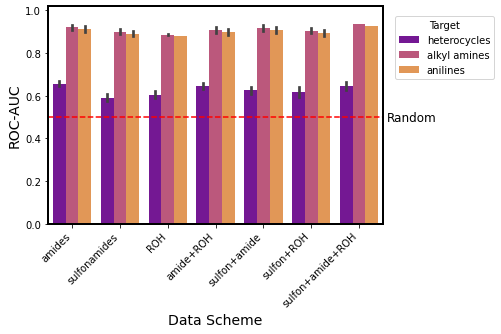

In [74]:
roc_barplot_by_data_scheme(prev_res,
                           data_scheme_list, True)